**Problem set 2: Olalla Nieto Faza**

In [7]:
# Import libraries
import qiskit
from qiskit.quantum_info import SparsePauliOp , Pauli
from qiskit.quantum_info import PauliList , Operator

import pandas as pd
import itertools
import numpy as np
from numpy import linalg as LA

from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.circuit import ParameterVector
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt

import sys
print(sys.version)

import qiskit_aer
print(qiskit_aer.__version__)

from qiskit_aer import AerSimulator

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
0.17.0


*2.1.1:  First, prove that:*
$$
e^{-itZ\otimes Z}=(C_1X_0)\left(e^{-it I\otimes Z} \right)(C_1X_0)=(C_1X_0)(I \otimes R_z(2t))(C_1X_0)
$$



**Step 1: Some useful things** 

**a)** $C_1X_0$ is a controlled-X (CNOT) gate with qubit 1 as the control qubit and qubit 0 as the target (if qubit 1 is $\ket{0}$, do nothing to qubit 0, if qubit 1 is $\ket{1}$, apply X (NOT) to qubit 0). This can be expressed as:

$$
C_1X_0= \ket{0}\bra{0}_1 \otimes I_0 + \ket{1}\bra{1}_1 \otimes X_0
$$

The projectors $\ket{0}\bra{0}$ and $\ket{1}\bra{1}$, I and X are all Hermitian and unitary, so

$$
(C_1X_0)^{\dagger}=C_1X_0         \quad\quad \text{is Hermitian}
$$

$$
(C_1X_0)^{\dagger}(C_1X_0)=I         \quad\quad \text{is unitary}
$$



**b)**  For a linear operator A and a unitary U:
$$
Ue^{A}U^{\dagger}=e^{UAU^{\dagger}}
$$
This can be shown using the definition of the matrix exponential
$$
e^{A}=\sum_{n=0}^{\infty}\frac{A^n}{n!}
$$
and applying the similarity transformation with the unitarian matrix U

$$
Ue^{A}U^{\dagger}=U\left(\sum_{n=0}^{\infty}\frac{A^n}{n!}\right)U^{\dagger} = \sum_{n=0}^{\infty}\frac{UA^nU^{\dagger}}{n!}
$$

As U is unitary  $ UA^nU^{\dagger}=\left(UAU^{\dagger}  \right)^n$ so the series becomes:

$$
Ue^{A}U^{\dagger}=\sum_{n=0}^{\infty}\frac{\left(UAU^{\dagger}\right)^n}{n!} = e^{UAU^{\dagger}}
$$



**c)**
Under conjugation with CNOT:
$$
\text{CNOT}_{1\rightarrow 0}(Z \otimes I) \text{CNOT}_{1\rightarrow 0} = Z \otimes Z
$$

$$
\text{CNOT}_{1\rightarrow 0}(I \otimes Z) \text{CNOT}_{1\rightarrow 0} = I \otimes Z
$$
$$
\text{CNOT}_{1\rightarrow 0}(X \otimes I) \text{CNOT}_{1\rightarrow 0} = X \otimes I
$$

$$
\text{CNOT}_{1\rightarrow 0}(I \otimes X) \text{CNOT}_{1\rightarrow 0} = X \otimes X
$$


So that:

$$
(C_1X_0)(Z\otimes Z)(C_1X_0) = I\otimes Z
$$

Checking it with matrices:

In [2]:
# define Pauli matrices:
sx = np.array([[0, 1], [1, 0]])
sz = np.array([[1, 0], [0, -1]])
si = np.array([[1, 0], [0, 1]])
# Define the CNOT gate matrix
CNOT = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]])

ZxZ=np.kron(sz,sz)
IxZ=np.kron(si,sz)

print("ZxZ=")
print(ZxZ)
print("IxZ=")
print(IxZ)

print("CNOT =")
print(CNOT)


product=np.matmul(CNOT, np.matmul(ZxZ,CNOT))
print("CNOT· (Z x Z) · CNOT= IxZ")
print(product)


ZxZ=
[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]]
IxZ=
[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0  1  0]
 [ 0  0  0 -1]]
CNOT =
[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
CNOT· (Z x Z) · CNOT= IxZ
[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0  1  0]
 [ 0  0  0 -1]]


**d)**

If we apply the definition of the exponential of an operator $e^{A}=\sum_{n=0}^{\infty}\frac{A^n}{n!}$  to  $e^{-it I\otimes Z}$:


$$
e^{-it I\otimes Z}= \sum_{n=0}^{\infty}\frac{(-it)^n (I\otimes Z)^n}{n!}
$$

Since I acts only on the subspace of qubit 1 and Z on the subspace of qubit 0, we can separate this expression into:

$$
(I\otimes Z)^n = I^n \otimes Z^n = I \otimes Z^n
$$

As a result:
$$
e^{-it I\otimes Z}= \sum_{n=0}^{\infty}\frac{(-it)^n }{n!}I \otimes Z^n=
I\otimes \left( \sum_{n=0}^{\infty}\frac{(-it)^nZ^n}{n!}  \right)=
I\otimes e^{-itZ}
$$



**Step 2:**

We start from  $(C_1X_0)\left(e^{-it I\otimes Z}\right) (C_1X_0)$ and use **a)** and **b)** so that:


$$
(C_1X_0)\left(e^{-it I\otimes Z}\right) (C_1X_0)=(C_1X_0)\left(e^{-it I\otimes Z} \right)(C_1X_0)^{\dagger}=e^{ (C_1X_0)(-it I\otimes Z)(C_1X_0)^{\dagger} }=
e^{ -it(C_1X_0)(I\otimes Z)(C_1X_0) }
$$


Using **c)** we get that 
$$
(C_1X_0)(I\otimes Z)(C_1X_0)= Z\otimes Z
$$
which we can replace in the previous expression, so that:
$$
(C_1X_0)\left(e^{-it I\otimes Z}\right) (C_1X_0)=e^{ -it(Z\otimes Z) }
$$
So we have proven the first equality in our statement.



**Step 3:**    

Now, we use **d)** to transform:
$$
e^{-it I\otimes Z} = I \otimes e^{-it Z}
$$

The single-qubit rotation around the Z-axis is defined as:

$$
R_z(\theta)=e^{-i\frac{\theta}{2}Z} = 
\begin{pmatrix} e^{-i\theta/2} &  0 \\ 0 &  e^{i\theta/2}\end{pmatrix}
$$
So:

$$
R_z(2t)=e^{-itZ}
$$

Substituting, we get that:

$$
e^{-it I\otimes Z}=I\otimes e^{-it Z}= I\otimes R_z(2t)
$$


So from the expression in **step 2** 

$$
(C_1X_0)\left(e^{-it I\otimes Z}\right) (C_1X_0)=e^{ -it(Z\otimes Z) }
$$

$$
e^{ -it(Z\otimes Z) }=(C_1X_0)\left(e^{-it I\otimes Z}\right) (C_1X_0)=
(C_1X_0)\left(I\otimes R_z(2t)\right)(C_1X_0)
$$

*2.1.2. Then, decompose $e^{-itZ\otimes Z \otimes Z \otimes Z}$ in terms of CNOT gates and single-qubit gates, and draw the corresponding circuit* 

In the operator $e^{-itZ\otimes Z \otimes Z \otimes Z}$  each of the Z operators acts on a single qubit, we can express it as $e^{-itZ_0Z_1Z_2Z_3}$. 

The Z operator acts as:

$$
Z\ket{0}=\ket{0}  \quad,\quad Z\ket{1}=-\ket{1}
$$

As a result, $Z\otimes Z \otimes Z \otimes Z$ measures the parity of the numbers of ones in the basis state (an even number of 1s leads to +1 eigenvalue and an odd number of 1s leads to -1).

$$
Z\otimes Z \otimes Z \otimes Z \ket{x_0x_1x_2x_3}=(-1)^{x_0+x_1+x_2+x_3}\ket{x_0x_1x_2x_3}
$$

Since $Z_0Z_1Z_2Z_3$ is Hermitian and unitary, and diagonal in the computatioanl basis (eigenvalues $\pm 1$) we can easily use the spectral decomposition for its exponentiation.  If $U=e^{-itZ_0Z_1Z_2Z_3}$ is applied to a state in the computational basis:

$$
U\ket{x}=e^{-it\lambda(x)}\ket{x} = e^{-it(-1)^{x_0+x_1+x_2+x_3}}\ket{x}
$$

The effect of this exponential operator is to apply a complex phase depending on the parity of 1s in the input state, it is a controlled-phase operation based on parity: if all qubits are in some state with even parity the phase applied is $e^{-it}$, if they are in a state with odd parity, the phase is $e^{it}$. 

As a result, we can reproduce its effect by computing the parity of the four qubit state using CNOT gates, then apply a phase rotation $R_z(2t)$ depending on the parity and then reverse the computation of the parity.


We can perform this decomposition using our previous result for two qubits:

$$
e^{ -it(Z_0Z_1) }=\text{CNOT}_{0\rightarrow 1}\left(I\otimes R_z(2t)\right)\text{CNOT}_{0\rightarrow 1}
$$

If we extend it to a   **three qubit** operator we want to reduce it to a rotation on just one qubit and CNOTs, so we need to look for a U that makes the following true:

$$
e^{ -it(Z\otimes Z \otimes Z) }= e^{ -it(Z_0Z_1Z_2) }= Ue^{ -it(Z_2) }U^{\dagger}
$$


If we define a $U=\text{CNOT}_{0\rightarrow 2}\text{CNOT}_{1\rightarrow 2}$

$$
UZ_2U^{\dagger}=\text{CNOT}_{0\rightarrow 2}\text{CNOT}_{1\rightarrow 2}Z_2 \text{CNOT}_{1\rightarrow 2}\text{CNOT}_{0\rightarrow 2}=
\text{CNOT}_{0\rightarrow 2}Z_1 Z_2 \text{CNOT}_{0\rightarrow 2}=
Z_0Z_1Z_2
$$

So through exponentiation:

$$
UZ_2U^{\dagger}= Z_0Z_1Z_2  \implies e^{-itZ_0Z_1Z_2}=Ue^{-itZ_2} U^{\dagger}
$$

That gives

$$
e^{-itZ_0Z_1Z_2}=\text{CNOT}_{0\rightarrow 2}\text{CNOT}_{1\rightarrow 2}e^{-itZ_2}
\text{CNOT}_{1\rightarrow 2}\text{CNOT}_{0\rightarrow 2}
$$

$$
e^{-itZ_0Z_1Z_2}=\text{CNOT}_{0\rightarrow 2}\text{CNOT}_{1\rightarrow 2}R_z(2t)_2
\text{CNOT}_{1\rightarrow 2}\text{CNOT}_{0\rightarrow 2}
$$


And for the **four qubit** case, with a parallel approach $U=\text{CNOT}_{0\rightarrow 3}\text{CNOT}_{1\rightarrow 3}\text{CNOT}_{2\rightarrow 3}$ and the desired decomposition would be:

$$
e^{-itZ_0Z_1Z_2Z_3}=\text{CNOT}_{0\rightarrow 3}\text{CNOT}_{1\rightarrow 3}\text{CNOT}_{2\rightarrow 3}Rz(2t)_3\text{CNOT}_{2\rightarrow 3}\text{CNOT}_{1\rightarrow 3}\text{CNOT}_{0\rightarrow 3}
$$


Now we prepare the corresponding quantum circuit:

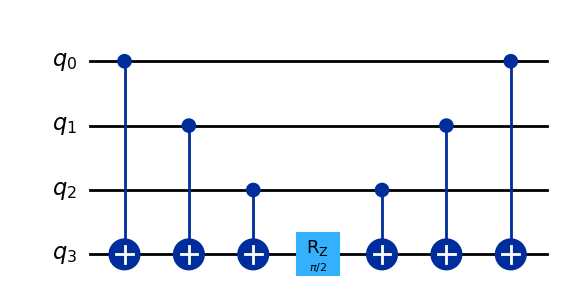

In [4]:
qc = QuantumCircuit(4)
# We need to define parameter t, we choose an arbitrary value at this point.
# The actual value of the angle is going to change the phase, not the actual state.
t = np.pi / 4 

# We apply the CNOT gates
#------------------------------
qc.cx(0, 3)
qc.cx(1, 3)
qc.cx(2, 3)

# We apply the rotation Rz(2t) on qubit 3
#-----------------------------------------
qc.rz(2 * t, 3)

# Apply CNOTs again in reverse order
qc.cx(2, 3)
qc.cx(1, 3)
qc.cx(0, 3)

# Draw the circuit
qc.draw('mpl')


Now we get the matrix corresponding to the circuit and we compare it with the matrix obtained analytically for the operator $e^{-itZ_0Z_1Z_2Z_3}$

In [15]:
from scipy.linalg import expm

# Get the unitary transformation associated to the whole circuit:
circuit_unitary = Operator(qc).data
#print(unitary)

# Now we build the matrix with Kronecker products and exponentiation:

ZxZ=np.kron(sz,sz)
ZxZxZ=np.kron(sz,ZxZ)
ZxZxZxZ=np.kron(sz,ZxZxZ)

expZZZZ=expm(-1j*t*ZxZxZxZ)
#print(expZZZZ)

# And now we compare the two matrices using np.allclose
# (a numerical comparison with tolerance)
#-------------------------------------------------------
are_equal = np.allclose(circuit_unitary,expZZZZ , atol=1e-10)
if are_equal:
    print("Matrices are equal (within numerical tolerance).")
else:
    print("Matrices are different.")


Matrices are equal (within numerical tolerance).


We find that the circuit is a good decomposition for this matrix.